In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.nn.functional as F
from fashion import fashion

In [2]:
'''
1. LOADING DATASET
'''
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x/255.0 for x in [63.0, 62.1, 66.7]])

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = fashion(root='./data', 
                            train=True, 
                            transform=transform,
                            download=True
                           )

test_dataset = fashion(root='./data', 
                            train=False, 
                            transform=transform,
                           )

Processing...
Done!


In [3]:
'''
2. MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 5500
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,            
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [4]:
'''
3: MODEL
'''

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32*4*4, 10)
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        # Linear function (readout)
        out = self.fc1(out)
        
        return out


In [5]:
'''
4. INSTANTIATE MODEL CLASS
'''

model = CNNModel()

In [9]:
'''
5. INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

In [11]:
'''
6. INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:

'''
7. TRAIN MODEL
'''
iter = 0
losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images)
        labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        losses.append(loss.data[0])

        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 500. Loss: 0.5933407545089722. Accuracy: 82
Iteration: 1000. Loss: 0.6860304474830627. Accuracy: 84
Iteration: 1500. Loss: 0.34704944491386414. Accuracy: 84
Iteration: 2000. Loss: 0.2904675006866455. Accuracy: 85
Iteration: 2500. Loss: 0.2996280789375305. Accuracy: 86
Iteration: 3000. Loss: 0.39251822233200073. Accuracy: 86
Iteration: 3500. Loss: 0.3602471649646759. Accuracy: 86
Iteration: 4000. Loss: 0.3139611482620239. Accuracy: 86
Iteration: 4500. Loss: 0.38216716051101685. Accuracy: 87
Iteration: 5000. Loss: 0.255622923374176. Accuracy: 87


In [164]:
### Save model
save_model = True
if save_model is True:
    #saves only params
    torch.save(model.state_dict(), 'fashion_model_rms_prop.pk1')

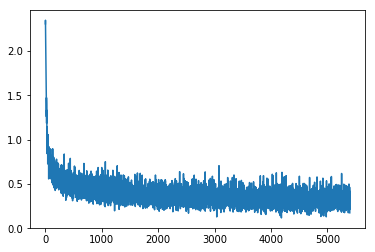

In [38]:
plt.plot(losses)

plt.savefig("new.png", trasparent = True)